# CBOW Embedding

- In this notebook there is an implementation of the model CBOW ( Word2vec), a model developed by Google to learn word embeddings, using tensorflow

In [1]:
import pickle
import numpy as np
import pandas as pd
import nltk
import string
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from random import choices
from scipy.sparse import dok_matrix, hstack, vstack
from scipy.spatial.distance import cosine

from sklearn.decomposition import PCA

from tensorflow.keras.layers import Input, Dot, Embedding, Dense, Flatten, Lambda, Concatenate, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD

In [2]:
all_words, docs = pickle.load(open("data/arxiv_abstracts_no_stopwords.pickle", "rb"))
rev_words = {item[1]:item[0] for item in all_words.items()}

In [3]:
M = len(all_words)
M

100649

In [4]:
def word2int(word):
    return all_words[word]

def int2word(idx):
    return rev_words[idx]

In [6]:
def get_dataset(docs, wsize=2):
    dataset = {}
    
    for doc in docs:
        N = len(doc)
        
        for i in range(wsize, N - wsize):
            current_word = word2int(doc[i])
            context_set = tuple()
            for j in range(1,wsize + 1):
                prev_word = word2int(doc[i - j])
                future_word = word2int(doc[i + j])
                
                context_set = context_set + (prev_word, future_word)
            context_set = tuple(sorted(context_set))
            
            dataset[context_set] = dataset.get(context_set, set()) | {current_word}
    return dataset

In [7]:
def unwind(dataset: dict):
    X = []
    y = []
    
    for item in dataset.items():
        xsample, ysamples = item
        for y_value in ysamples:
            X.append(xsample)
            y.append(y_value)
    return np.array(X), np.array(y).reshape(-1,1)

In [8]:
wsize=4

In [9]:
ds = get_dataset(docs, wsize)

In [10]:
X,y = unwind(ds)

In [11]:
EMB_SIZE=50

In [12]:
model = Sequential([
    Embedding(
        input_dim=M, 
        output_dim=EMB_SIZE, 
        input_length=wsize*2,
        name="embeding_layer"),
    Lambda(lambda x: tf.keras.backend.mean(x, axis=1), output_shape=EMB_SIZE, name="mean_layer"),
    Dense(units=M, activation="softmax", name="activation_layer")
])
    

In [13]:
model.compile("adam", loss="sparse_categorical_crossentropy")

In [16]:
model.fit(x=X, y=y, batch_size=512, epochs=1)

3808/3808 [==============================] - 289s 76ms/step - loss: 8.0778


In [18]:
embed_vectors = model.get_weights()[0]

In [19]:
pca = PCA().fit_transform(embed_vectors)

In [20]:
np.argsort([ 
    euclidean(
        pca[word2int("cnn")], 
        pca[i]
    ) for i in range(len(pca))
])[:15]

array([  992, 35272, 21118, 63027, 64978, 49243, 92797, 66506, 86974,
       84225, 65059, 37748,   489, 66504, 90360], dtype=int64)

In [22]:
int2word(21118)

'mimt-cnn'

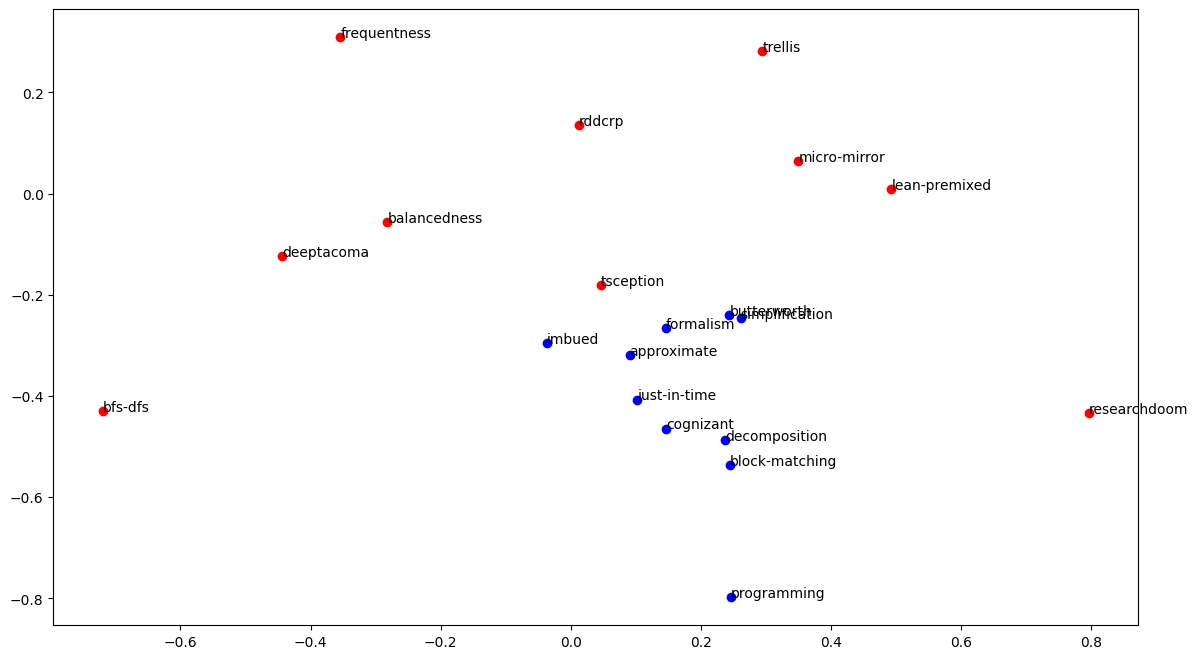

In [23]:
k=10
prog_near = np.argsort([ 
    euclidean(
        pca[word2int("programming")], 
        pca[i]
    ) for i in range(len(pca))
])[:k]

random = np.random.choice(list(range(len(pca))), size=k, replace=False)

plt.figure(figsize=(14,8))
for i in prog_near:
    plt.scatter(pca[i,0], pca[i,1], c="b") #int2word(i))
    plt.text(pca[i,0], pca[i,1],int2word(i))
    
for i in random:
    plt.scatter(pca[i,0], pca[i,1], c="r") 
    plt.text(pca[i,0], pca[i,1],int2word(i))